# Part 1: Gene Expression Clustering

In this exercise, gene expression data for 7,129 genes across 72 samples will be divided into clusters using a K-means algorithm. 

## Importing Packages

In the initial step, relevant Python packages are imported. Note that some packages will be used in Part 2, but are not necessarily used in Part 1.

In [1]:
# ==IMPORT PACKAGES============================================================
import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn import metrics
from sklearn import neighbors
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import (confusion_matrix, classification_report)
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import (GridSearchCV, cross_val_score, KFold)

## Importing Data

Next, the data itself is imported from an external .tsv file and stored in a pandas data table. Because the raw data is initially stored as gene expression levels in rows and samples in columns, the data is transposed to sort the variables (genes expression levels) as columns instead. The data is then scaled, which sets the transforms the mean across each variable to 0 and the standard deviation to 1. This will allow for greater resolution and a more accurate representation in principle components analysis.

In [2]:
# ==IMPORT AND MANAGE DATA=====================================================
data = pd.read_table("data.tsv")
gene_numbers = data["Genes"]
# Sets a new name for the first column
gene_numbers = gene_numbers.rename("Patient")
# Removes the gene number column, then transposes the table
data = data.drop("Genes", axis=1).T
# Renames the columns
data.columns = gene_numbers
# Scales the data
data_scaled = pd.DataFrame(scale(data), index=data.index, columns=data.columns)

## Principle Component Analysis


PCA can now be performed. This will reduce the dimensions of the dataframe down to a set of principle components, which explain the bulk of the variance in fewer variables. This also enables visualization of the data's distribution across these principle components.

In [3]:
# ==PERFORM PCA================================================================
pca = PCA()
data_plot = pd.DataFrame(pca.fit_transform(data_scaled))

### Examining the Principle Components

Scree plots can be used to begin analyzing which principle components explain most of the variance. The plots below shows the proportion of the data's variance explained by each principle component, as well as the cumulative variance explained by increasing numbers of principle components.

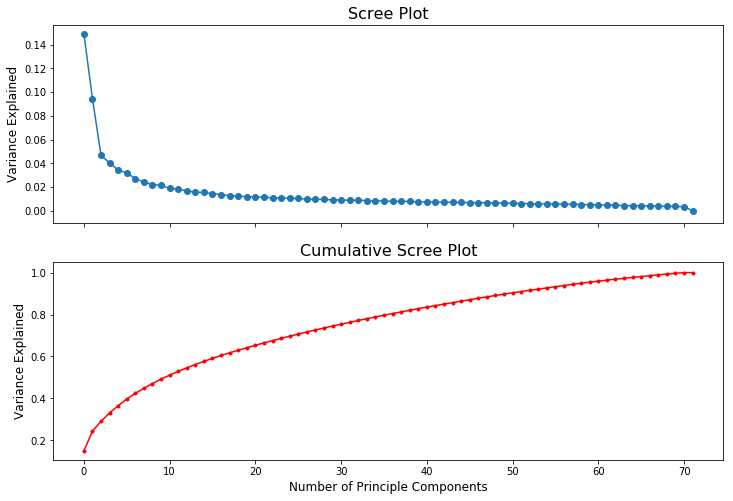

In [4]:
# ==SCREE PLOTS===============================================================
fig, (scree, scree_cum) = plt.subplots(2, 1, figsize=(12, 8), sharex='col')

scree.plot(pca.explained_variance_ratio_, '-o')
scree.set_ylabel('Variance Explained', size=12)
scree.set_ylim(ymin=-0.01)
scree.set_title('Scree Plot', size=16)

scree_cum.plot(np.cumsum(pca.explained_variance_ratio_), '-r.')
scree_cum.set_xlabel("Number of Principle Components", size=12)
scree_cum.set_ylabel('Variance Explained', size=12)
scree_cum.set_ylim(ymax=1.05)
scree_cum.set_title('Cumulative Scree Plot', size=16)
plt.show()
plt.close()

These plots explain that most of the variance is explained in only the first few principle components, and that further dimensions each explain variance in diminishing amounts.


### Visualizing PCA

The plot matrix below shows principle components 1, 2, 3, and 4 plotted against each other. This is useful for identifying any immediately obvious levels of structure in the data. Note that the diagonal represents a principle component plotted against itself, and so shows a diagonal line.

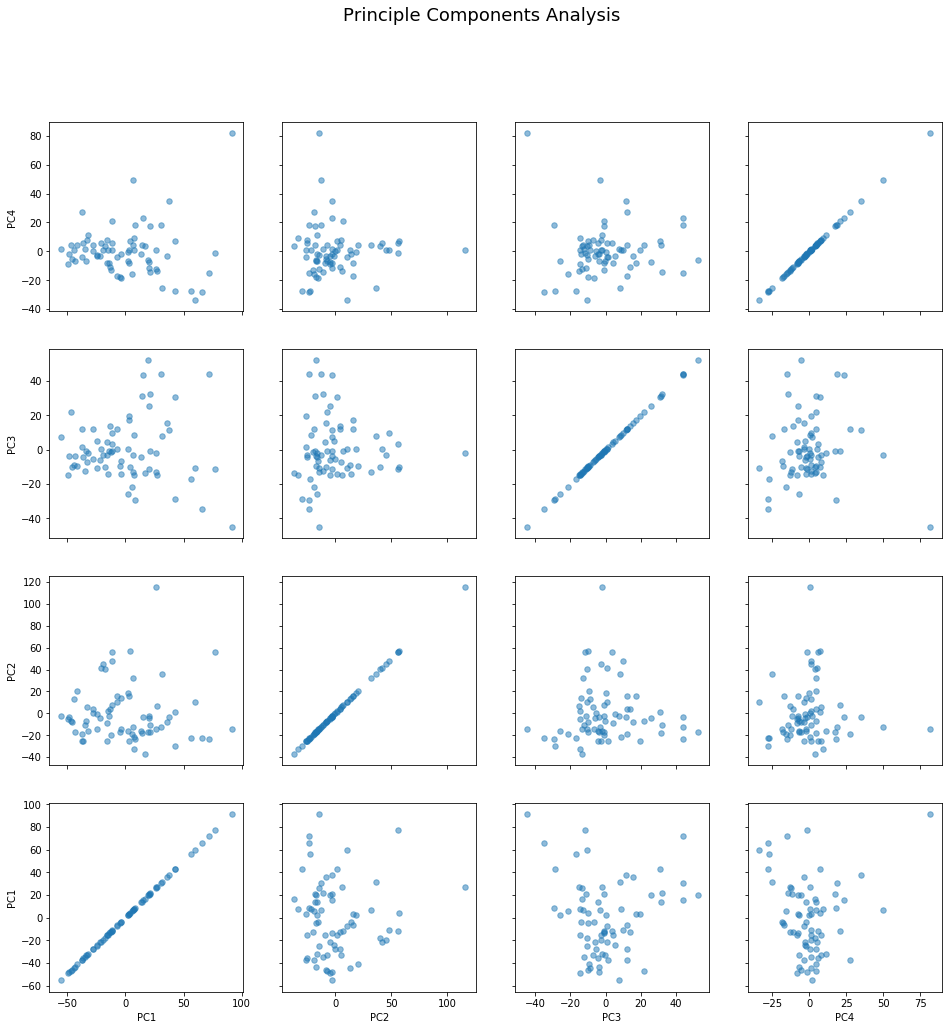

In [5]:
# ==PCA COMPARISON FOR 0, 1, 2, AND 3==========================================
fig, ((ax0, ax1, ax2, ax3),
      (ax4, ax5, ax6, ax7),
      (ax8, ax9, ax10, ax11),
      (ax12, ax13, ax14, ax15)) = plt.subplots(4, 4, sharex='col', sharey='row', figsize=(16, 16))

ax0.scatter(data_plot.iloc[:, 0], data_plot.iloc[:, 3], alpha=0.5, s=30)
ax0.set_ylabel("PC4")
ax1.scatter(data_plot.iloc[:, 1], data_plot.iloc[:, 3], alpha=0.5, s=30)
ax2.scatter(data_plot.iloc[:, 2], data_plot.iloc[:, 3], alpha=0.5, s=30)
ax3.scatter(data_plot.iloc[:, 3], data_plot.iloc[:, 3], alpha=0.5, s=30)
ax4.scatter(data_plot.iloc[:, 0], data_plot.iloc[:, 2], alpha=0.5, s=30)
ax4.set_ylabel("PC3")
ax5.scatter(data_plot.iloc[:, 1], data_plot.iloc[:, 2], alpha=0.5, s=30)
ax6.scatter(data_plot.iloc[:, 2], data_plot.iloc[:, 2], alpha=0.5, s=30)
ax7.scatter(data_plot.iloc[:, 3], data_plot.iloc[:, 2], alpha=0.5, s=30)
ax8.scatter(data_plot.iloc[:, 0], data_plot.iloc[:, 1], alpha=0.5, s=30)
ax8.set_ylabel("PC2")
ax9.scatter(data_plot.iloc[:, 1], data_plot.iloc[:, 1], alpha=0.5, s=30)
ax10.scatter(data_plot.iloc[:, 2], data_plot.iloc[:, 1], alpha=0.5, s=30)
ax11.scatter(data_plot.iloc[:, 3], data_plot.iloc[:, 1], alpha=0.5, s=30)
ax12.scatter(data_plot.iloc[:, 0], data_plot.iloc[:, 0], alpha=0.5, s=30)
ax12.set_ylabel("PC1")
ax12.set_xlabel("PC1")
ax13.scatter(data_plot.iloc[:, 1], data_plot.iloc[:, 0], alpha=0.5, s=30)
ax13.set_xlabel("PC2")
ax14.scatter(data_plot.iloc[:, 2], data_plot.iloc[:, 0], alpha=0.5, s=30)
ax14.set_xlabel("PC3")
ax15.scatter(data_plot.iloc[:, 3], data_plot.iloc[:, 0], alpha=0.5, s=30)
ax15.set_xlabel("PC4")
plt.suptitle("Principle Components Analysis", size=18)
plt.show()
plt.close()

While significant clustering structure isn't terribly obvious in any of the comparisons above, PC1 and PC2 will be used to explore whether clustering can be performed via K-Mean. As such, these first two principle components are extracted and stored in a new dataframe.

In [6]:
# ==EXTRACT PCA 0 and 1=======================================================
pc_array = np.column_stack((pd.Series.tolist(data_plot[0]),
                            pd.Series.tolist(data_plot[1])))

## K-Mean Clustering

K-Means clustering can now be performed. In this method, arbitrary centers are established. Each sample is then assigned to a center, and a new center is calculated based off of each grouping. Samples are then reassigned based off of the new centers, and the process is repeated. The algorithm terminates once samples no longer move, and the mean centers remain fixed.

### Determing Optimal Number of Clusters

To perform K-Mean clustering, a desired number of clusters must first be established. Rather than choosing an intuitive or arbitrary number, however, multiple clusterings can be performed with different numbers of clusters to compare performance. Two measures of performance will be used here:
* **Inertia** represents the total distance of each sample to its respective cluster. High inertia indicates that clusters are large and loose-fitting, while low-inertia indicated tighter-fitting clusters. Inertia will tend towards zero, reaching it when the number of clusters equals the number of samples, resulting in perfectly fitting but zero-information clusters. Therefore, a balance must be struck between fit and useful information.

* **Silhouette Scores** represent the level of definition of the clusters. To generate a silhouette score, the intra- and inter-cluster distances for each sample are compared. Ideally, inter-cluster distance should be much greater than intra-cluster distance and results in silhouette scores approaching 1, while low or negative scores indicate potentially overlapping clusters.

Both of these scores are used to generate plots across increasing numbers of clusters.

### Elbow and Silhouette Plots


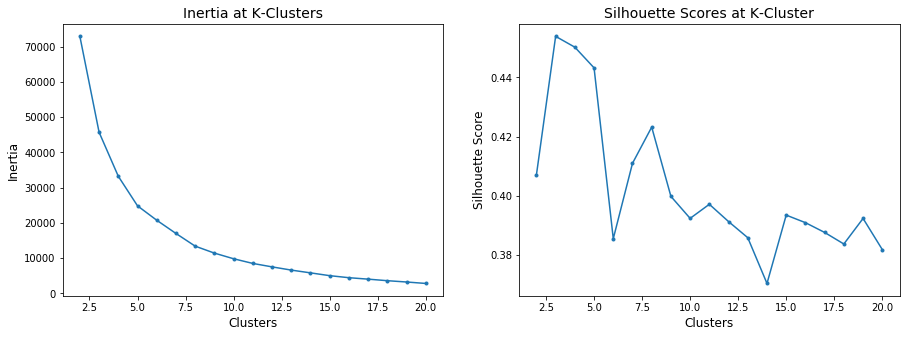

In [7]:
# ==ELBOW AND SILHOUETTE PLOTS============================================
inertias = []
silhs = []
for x in range(2, 21):
    kmean_x = KMeans(n_clusters=x,  random_state=1, n_init=150)
    kmean_x.fit(pc_array)
    inertias.append(kmean_x.inertia_)
    silhs.append(metrics.silhouette_score(pc_array, kmean_x.labels_))

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(2, 21), inertias, marker=".")
plt.title("Inertia at K-Clusters", size=14)
plt.xlabel("Clusters", size=12)
plt.ylabel("Inertia", size=12)

plt.subplot(122)
plt.plot(range(2, 21), silhs, marker=".")
plt.title("Silhouette Scores at K-Cluster", size=14)
plt.xlabel("Clusters", size=12)
plt.ylabel("Silhouette Score", size=12)
plt.show()
plt.close()

The Elbow Plot at left above shows the expected decrease in inertia as clusters increase. However, the "elbow" point refers to the point of inflection in the decrease in inertia. In other words, the elbow point shows where the improvement in inertia begins to taper off, such that increasing the number of clusters results in only low benefits to inertia. In this plot, this point appears between 5 and 8 clusters.

The Silhouette Score plot at right above shows the scores generated in the resultant clustering pattern with K clusters. For example, 6 clusters results in a pattern of clustering that may result in elevated overlap compared to 5 or 7 clusters. The plot shows that 3 clusters results in optimal silhouette score, and that 4 and 5 clusters are comparable.

### Clustering

Based off of the silhouette and inertia scores, 4 and 5 clusters will be used and compared.

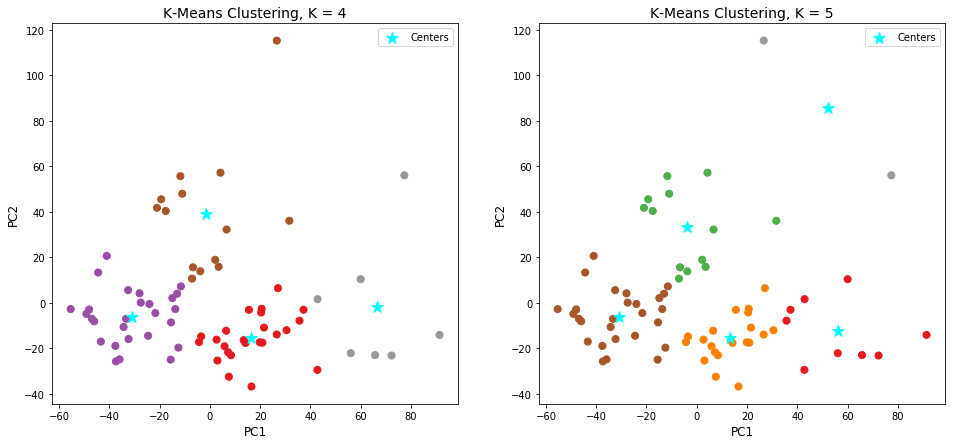

In [8]:
# ==CLUSTERING===============================================================
kmean_4 = KMeans(n_clusters=4)
kmean_4.fit(pc_array)
kmean_5 = KMeans(n_clusters=5)
kmean_5.fit(pc_array)


plt.figure(figsize=(16, 7))

plt.subplot(121)
plt.scatter(pc_array[:, 0], pc_array[:, 1], s=50,
            c=kmean_4.labels_, cmap=plt.cm.Set1)
plt.scatter(kmean_4.cluster_centers_[:, 0],
            kmean_4.cluster_centers_[:, 1],
            marker='*', s=150, color='cyan', label='Centers')
plt.legend(loc='best')
plt.xlabel('PC1', size=12)
plt.ylabel('PC2', size=12)
plt.title("K-Means Clustering, K = 4", size=14)

plt.subplot(122)
plt.scatter(pc_array[:, 0], pc_array[:, 1], s=50,
            c=kmean_5.labels_, cmap=plt.cm.Set1)
plt.scatter(kmean_5.cluster_centers_[:, 0],
            kmean_5.cluster_centers_[:, 1],
            marker='*', s=150, color='cyan', label='Centers')
plt.legend(loc='best')
plt.xlabel('PC1', size=12)
plt.ylabel('PC2', size=12)
plt.title("K-Means Clustering, K = 5", size=14)
plt.show()
plt.close()

## Conclusions

Clusters have been generated from the gene expression data, grouping them by position in principle component space. The clustering observed from 4 to 5 clusters does not change mean center position, but rather adds a 5th cluster that represents the 2 most extreme points. This may indicate further confidence in the 4 clusters presented, as they are still represented in the 5-cluster plot. Intuitively, the clusters drawn from the plot appear to represent true, albeit hazy, clusters. Statistically, these clusters do not show a great deal of confidence, based off of the ~0.45 silhouette score and the small changes between fringe samples. 

To further this analysis, it may be possible and interesting to deconstruct the vector contributions to the principle components, thereby observing which variables contribute the most to the clustering effect in the data.

***

# Part 2: Classifiers and the Wisconsin Data Set

In this section, three machine learning algorithm classifiers will be trained on the provided Wisconsin Diagnostic Breast Cancer 1995 dataset, which contains 9 variable measurements from imaging of nuclei from breast mass fine-needle aspirates. To test these classifying methods, an additional set of 16 patient samples will be passed into the algorithms to compare the predicted classifications with the classifications on file. These 16 patients were initially missing information on "bare nucleoli" measurements, and were then excluded. For the purpose of this exercise, random data has been drawn from the rest of the Wisconsin Breast Cancer dataset to fill in this gap. 

Afterwards, the same algorithms will be run against these 16 samples again. However, rather than filling in the missing information with a random distribution from the rest of the data, the missing variable information will be set to the median of value of the rest of the data, essentially creating a variable with zero variance to analyze the variable's contribution to the classification algorithm. 

## Importing Data

The classifications in question in this dataset are either "malignant" or "benign", and each patient's status has already been assigned. Therefore, this information will be removed from the dataset, along with the non-informative patient ID column.

In [9]:
# ==IMPORT AND MANAGE DATA====================================================

# Import Wisconsin data set
wisc_raw = pd.read_csv("breast-cancer-wisconsin.csv")
#Store patient IDs for reference
id_list = wisc_raw["id"].tolist()
#Store known classification of each sample
classes = wisc_raw["class"].tolist()
#Remove ID numbers and classes from dataset
wisc_raw = wisc_raw.drop("id", axis=1)
wisc_raw = wisc_raw.drop("class", axis=1)
#Record the number of samples in the dataset
wisc_len = len(wisc_raw)

#Repeat for new patient dataset
new_raw = pd.read_csv("new_data.csv")
id_list_new = new_raw["id"].tolist()
classes_new = new_raw["class"].tolist()
new_raw = new_raw.drop("id", axis=1)
new_raw = new_raw.drop("class", axis=1)

After obtaining the two trimmed datatables, they are then combined temporarily for the purposes of scaling each variable to a mean of zero and standard deviation of one. The data are then resegregated into their respective tables again.

In [10]:
#Combine the datatables
frames = [wisc_raw, new_raw]
whole = pd.concat(frames, ignore_index=True)
#Scale each variable
whole = pd.DataFrame(scale(whole), columns=whole.columns)

#Extract scaled data
wisc = pd.DataFrame(whole[:wisc_len], columns=whole.columns)
new = pd.DataFrame(whole[wisc_len:], columns=whole.columns)


To further standardize the datasets, the recorded classes for "benign" and "malignant", which are originally recorded as "2" or "4", are changed to a simple "0" and "1", respectively.

In [11]:
# ==CHANGE CLASSES TO 0 AND 1=================================================
for i in range(len(classes)):
    if classes[i] == 2:
        classes[i] = 0
    elif classes[i] == 4:
        classes[i] = 1

for i in range(len(classes_new)):
    if classes_new[i] == 2:
        classes_new[i] = 0
    elif classes_new[i] == 4:
        classes_new[i] = 1


## Principle Component Analysis

To begin examining the variance in the data, a Principle Components Analysis is first performed, allowing the data to be reduced to its most informative dimensions.

In [12]:
# ==PCA=======================================================================
pca2 = PCA()
#Perform PCA on the Wisconsin set, and save to a new dataframe
pca_wisc = pd.DataFrame(pca2.fit_transform(wisc))
pc12_wisc = np.column_stack((pd.Series.tolist(pca_wisc[0]),
                             pd.Series.tolist(pca_wisc[1])))

#Do the same for the new patient set
pca_new = pd.DataFrame(pca2.fit_transform(new))
pc12_new = np.column_stack((pd.Series.tolist(pca_new[0]),
                            pd.Series.tolist(pca_new[1])))



The following graph show the first two principle components of each dataset plotted in one figure. According to this PCA, most of the new data falls in a small cluster, somewhat similar to the full dataset, while a few points fall further away, along the same axes as the full set.

While this new data does show similar structure to the rest of the dataset, there does exist some lack of representation in the center of this 2-dimensional compression. This indicates that while the new patient set can be used as a test of classification, it is possible that it might not give a full accounting of how well-trained the classifiers are.

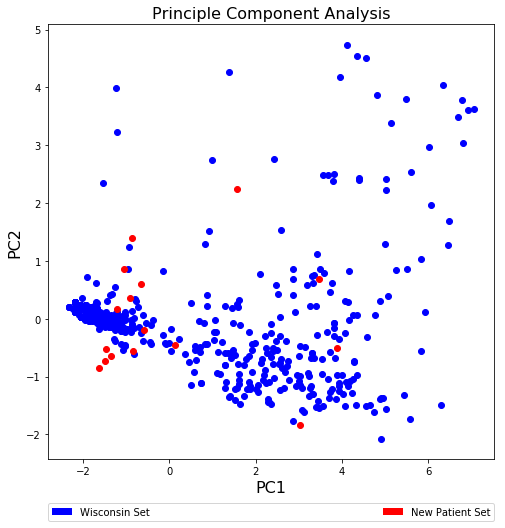

In [13]:
plt.figure(figsize=(8, 8))

colors = ['blue', 'red']
plt.title('Principle Component Analysis', size=16)
plt.xlabel("PC1", fontsize=16)
plt.ylabel('PC2', fontsize=16)

plt.scatter(pc12_wisc[:, 0], pc12_wisc[:, 1], color='b')
plt.scatter(pc12_new[:, 0], pc12_new[:, 1], color='r')

class_types = ['Wisconsin Set', 'New Patient Set']
recs = []
for i in range(0, len(colors)):
    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colors[i]))

plt.legend(recs, class_types, bbox_to_anchor=(0, -0.2, 1, 0.1), loc=2,
           ncol=2, mode="expand", borderaxespad=0)
plt.show()
plt.close()

## K-Nearest Neighbors Classifier

The first classifier that will be used is the **K-Nearest Neighbors** algorithm. In this method, each sample is essentially assigned a class based off of the classes of its closest neighbors. However, the size of each sample's "neighborhood" can affect the outcome. Therefore, rather than choosing an arbitrary size of each neighborhood, a cross-validation technique will be used to establish an optimal number of neighbors to consider as a group.

### KNN Cross-Validation

To cross-validate the KNN method, a K-Folds method will be used. This involves repeatedly cutting the training data set (in this case, the Wisconsin set) into different chunks of data. One chunk is then used as a test, while the other chunks are used to train, reducing the risk of overfitting. This procedure is repeated for different values of *k* neighbors, and the resulting accuracy of the training/testing prediction across all chunks is then recorded for that *k*. 

In [14]:
# ==K-FOLD KNN CROSS_VALIDATION===============================

# Neighbor numbers to check
neighbor_list = list(range(1, 20))
# Number of folds to use
kfold = KFold(n_splits=5, random_state=99)
# List of cross-validation mean accuracy scores per k
cv_scores = []
for k in neighbor_list:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, pc12_wisc, classes, cv=kfold,
                             scoring="accuracy")
    cv_scores.append(scores.mean())
# The number of neighbors k that yields the maximum accuracy in training
optimal_k = neighbor_list[cv_scores.index(max(cv_scores))]

After obtaining this list of accuracy values, the results can then be visualized. The graph below shows the resulting accuracy of the trained KNN method versus the number of *k* neighbors used. The *k* value yielding the highest accuracy is also shown.

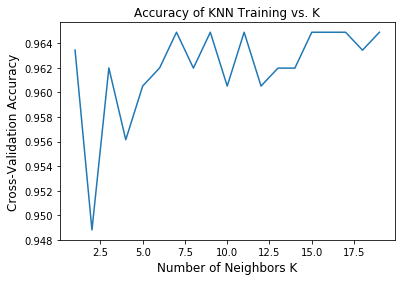

Maximum Accuracy at 7 neighbors.


In [15]:
plt.plot(neighbor_list, cv_scores)
plt.title("Accuracy of KNN Training vs. K")
plt.xlabel('Number of Neighbors K', size=12)
plt.ylabel('Cross-Validation Accuracy', size=12)
plt.show()
plt.close()
print("Maximum Accuracy at {} neighbors.".format(optimal_k))

***
## KNN Applied

With an optimal number of neighbors obtained, the KNN can then be applied to the test data. In the code below, a K-Nearest Neighbors classifier is constructed using 7 neighbors, and is then used to predict the classes of the new patient data set, based off of neighboring positions in the principle component space.

In [16]:
# ==KNN WITH VALIDATED k-NEIGHBORS===========================================
knn7 = neighbors.KNeighborsClassifier(n_neighbors=optimal_k)
# Applying the KNN to the new patient set to predict their classes
pred7 = knn7.fit(pc12_wisc, classes).predict(pc12_new)

The results of the KNN prediction are shown below, compared side-by-side with the pre-recorded patient classes. Note the differences in patients 2, 12, and 13. 

In [17]:
print("Recorded from data: ", list(classes_new))
print("Predicted from KNN: ", list(pred7))

Recorded from data:  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Predicted from KNN:  [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0]


***
These results can be summarized in a **confusion matrix**, which shows true/false negatives and false/true positives. Further insights into classifier performance can be obtained by the classification report summary. These metrics show that the classifier has a high false positive rate and low precision, though it was sensitive enough to catch all true positives.

In [18]:
print("Summary Matrix:")
print(confusion_matrix(classes_new, pred7).T)
print("\nClassification Report:\n")
print(classification_report(classes_new, pred7, digits=3))

# Get metrics on KNN test results
conf_mat_7 = metrics.confusion_matrix(classes_new, pred7)
TP7 = conf_mat_7[1, 1]*1.0
TN7 = conf_mat_7[0, 0]*1.0
FP7 = conf_mat_7[0, 1]*1.0
FN7 = conf_mat_7[1, 0]*1.0
print("Accuracy: {:.3%}".format((TP7 + TN7) / (TP7 + TN7 + FP7 + FN7)))
print("Sensitivity: {:.3%}".format(TP7 / (FN7 + TP7)))
print("Precision: {:.3%}".format(TP7 / (FP7 + TP7)))
print("False Positive Rate: {:.3%}".format(FP7 / (FP7 + TN7)))


Summary Matrix:
[[11  0]
 [ 3  2]]

Classification Report:

             precision    recall  f1-score   support

          0      1.000     0.786     0.880        14
          1      0.400     1.000     0.571         2

avg / total      0.925     0.812     0.841        16

Accuracy: 81.250%
Sensitivity: 100.000%
Precision: 40.000%
False Positive Rate: 21.429%


### KNN Results Visualized

The prediction results of the KNN algorithm can now be plotted in principle component space.

In [19]:
# ==PLOTTING FUNCTION===============================================
def my_plots(classifier, predicted_classes):
    # All data distribution comparison
    plt.figure(figsize=(15, 4))
    a = plt.subplot(131)

    colors = ['blue', 'red']
    plt.title('Distribution of All Samples')
    plt.ylabel('PC2', fontsize=16)

    plt.scatter(pc12_wisc[:, 0], pc12_wisc[:, 1], color='b')
    plt.scatter(pc12_new[:, 0], pc12_new[:, 1], color='r')

    class_types = ['Train', 'Test']
    recs = []
    for i in range(0, len(colors)):
        recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colors[i]))

    plt.legend(recs, class_types, bbox_to_anchor=(0, -0.2, 1, 0.1), loc=2,
               ncol=2, mode="expand", borderaxespad=0)

    # Known classes
    plt.subplot(132, sharex=a, sharey=a)

    colors = ['green', 'red']
    plt.title('Known Class of All Samples')
    plt.xlabel('PC1', labelpad=30, fontsize=16)

    plt.scatter(pc12_wisc[:, 0], pc12_wisc[:, 1], c=classes,
                cmap=matplotlib.colors.ListedColormap(colors))
    plt.scatter(pc12_new[:, 0], pc12_new[:, 1], c=classes_new,
                cmap=matplotlib.colors.ListedColormap(colors))

    class_types = ['Benign', 'Malignant']
    recs = []
    for i in range(0, len(colors)):
        recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colors[i]))

    plt.legend(recs, class_types, bbox_to_anchor=(0, -0.2, 1, 0.1), loc=2,
               ncol=2, mode="expand", borderaxespad=0)

    # Predicted results outcome
    plt.subplot(133, sharex=a, sharey=a)

    colors = ['green', 'red', 'black']
    plt.title('{} Classification Test Results'.format(classifier))

    new_labels = list(predicted_classes)
    for i in range(len(predicted_classes)):
        if predicted_classes[i] != classes_new[i]:
                new_labels[i] = 2

    plt.scatter(pc12_new[:, 0], pc12_new[:, 1],
                c=new_labels, cmap=matplotlib.colors.ListedColormap(colors))

    class_types = ['Benign', 'Malignant', 'Mis-classified']
    recs = []
    for i in range(0, len(colors)):
        recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colors[i]))

    plt.legend(recs, class_types, bbox_to_anchor=(0, -0.2, 1, 0.1), loc=2,
               ncol=3, mode="expand", borderaxespad=0)

    plt.subplots_adjust(wspace=.1)
    plt.show()
    plt.close()

The three graphs below, called by the plotting function defined above, first show the previously-shown distribution of the new patient data compared to the full Wisconsin set. The center graph then shows the pre-recorded classes of each patient in both sets combined. Finally, the figure at right shows the class predictions of the new samples according to the KNN classifier.

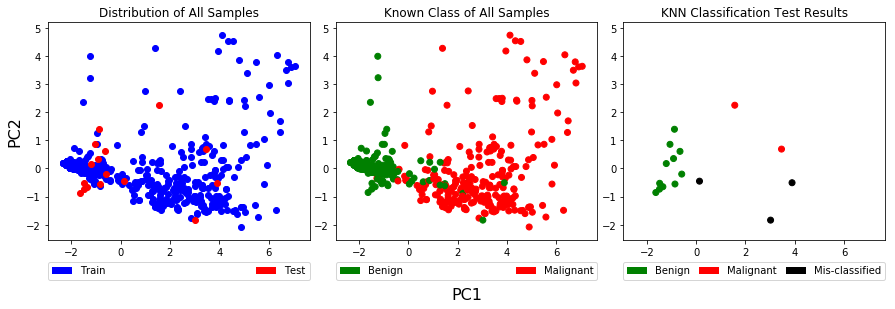

In [20]:
my_plots("KNN", pred7)

As shows above, the KNN classifier differed from the pre-recorded classes of three patients, two of which are visual outliers. These results will now be compared to a second method, the Support Vector Machine.

## Support Vector Machine

The second classifier that will be used is a **Linear Support Vector Machine**. This classifier seeks to partition the samples in principle component space into two groups using a linear partition, aiming to maximize the distance between classes in the training dataset. (While a non-linear radial SVM can also be used, this was found to perform worse than the linear SVM for this dataset.) 

### SVM Function

This method will begin with importing a pre-defined function for plotting the Support Vector Classifier results.

In [21]:
# ==SUPPORT VECTOR MACHINE FUNCTION========================================
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)
    plt.scatter(X[:, 0], X[:, 1], s=70, c=y, cmap=plt.cm.Paired)
# Support vectors indicated in plot by vertical lines
    sv = svc.support_vectors_
    plt.scatter(sv[:, 0], sv[:, 1], c='k', marker='|', s=100, linewidths='1')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)


### Cross-Validation of the SVM

The Linear SVM takes one user-defined parameter, *C*, which defines how error affect the classifier. Smaller values of *C* indicate that a wider separation between classes should be found, even if some samples are misclassified, while a larger value of *C* indicates that a narrow separation is acceptable, favoring correct classifications in the training data.

To decide what *C* value to use for the SVM, GridSearchCV is used to calculate which *C* value from a selection yields the highest accuracy, using partitions of the training set as tests.

In [22]:
# ==LINEAR KERNEL SVM=========================================================
# Get best C value
tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}]
clf = GridSearchCV(SVC(kernel='linear'),
                   tuned_parameters, cv=10, scoring='accuracy')
clf.fit(pc12_wisc, classes)
clf.cv_results_
print("Best C Value:", clf.best_params_["C"])
print('{:.3%} of test observations misclassified'.format(
        (1 - clf.best_estimator_.score(pc12_wisc, classes))))

Best C Value: 0.01
2.928% of test observations misclassified


***
Having obtained an optimal *C* value via cross-validation, the linear SVM will be trained on the Wisconsin data set. The graph below shows the SVM training results, splitting the data into two classes.

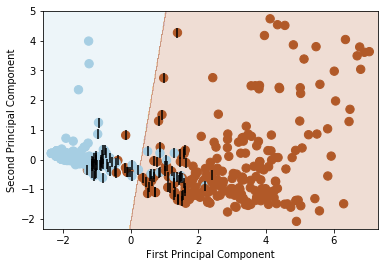

Number of support vectors:  108


In [23]:
# Train the linear SVC
svc = SVC(C=0.01, kernel='linear')
svc.fit(pc12_wisc, classes)
plot_svc(svc, pc12_wisc, classes)

### Testing the SVM

Now that the SVM has been trained, the SVM can be run on the new patient data set to test its predictive accuracy. As with the KNN, a confusion matrix and classification report are obtained to help analyze the results.

In [24]:
# Run the linear SVC test
pred_svc = svc.predict(pc12_new)


print("Recorded from data: ", list(classes_new))
print("Predicted from SVM: ", list(pred_svc))

# Get metrics on linear test results
print("\nConfusion Matrix:\n")
print(confusion_matrix(classes_new, pred_svc).T)
print("\nClassification Report:\n")
print(classification_report(classes_new, pred_svc, digits=3))

conf_mat2 = metrics.confusion_matrix(classes_new, pred_svc)
TP2 = conf_mat2[1, 1]*1.0
TN2 = conf_mat2[0, 0]*1.0
FP2 = conf_mat2[0, 1]*1.0
FN2 = conf_mat2[1, 0]*1.0

print("Accuracy: {:.3%}".format((TP2 + TN2) / (TP2 + TN2 + FP2 + FN2)))
print("Sensitivity: {:.3%}".format(TP2 / (FN2 + TP2)))
print("Precision: {:.3%}".format(TP2 / (FP2 + TP2)))
print("False Positive Rate: {:.3%}".format(FP2 / (FP2 + TN2)))

Recorded from data:  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Predicted from SVM:  [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]

Confusion Matrix:

[[12  0]
 [ 2  2]]

Classification Report:

             precision    recall  f1-score   support

          0      1.000     0.857     0.923        14
          1      0.500     1.000     0.667         2

avg / total      0.938     0.875     0.891        16

Accuracy: 87.500%
Sensitivity: 100.000%
Precision: 50.000%
False Positive Rate: 14.286%


***
Two patients were classified differently in the SVM versus the prerecorded classes, as opposed to the KNN's three. Note that again, two of the misclassified samples are 2 and 13. 

### Visualizing the SVM Results

The classifier results from the SVM can now be visualized in principal component space to inspect how samples were classified.

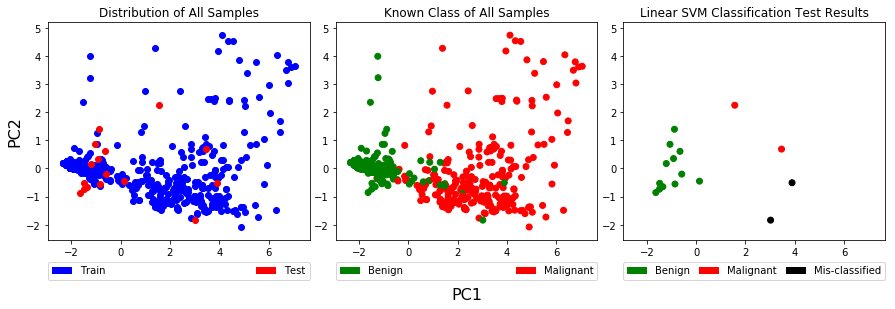

In [25]:
# ==LINEAR KERNEL SVC PLOT===================================================
my_plots("Linear SVM", pred_svc)

Once again, 2 of the outlying points in the distribution were misclassified. This may indicate poor performance of the SVM training. However, due to its similarity to the KNN method, further investigation is warranted. As such, a Random Forest Classifier will now be used.

## Random Forest Classifier

The **Random Forest Classifier** operates by creating many binary decision trees, essentially making many hypothetical classifications based off of sample variable scores. The results are then combined into the final Random Forest Classifier. It is important to note that this classifier will not be run on the PCA transformed data, but rather the scaled full data so as to preserve individual variable's contributions to the trees. 

### Cross-Validation of the Random Forest

In order to robustly train the random forest, a **K-Folds** cross-validation will again be used, as in the KNN cross-validation. This will allow the random forest to train on many subsets of the Wisconsin dataset without overfitting caused by testing on training data. After this training, the classifier's accuracy is displayed.

In [26]:
# ==RANDOM FOREST=============================================================
cv_folds = KFold(n_splits=5, random_state=0)
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_cv_score = cross_val_score(rf_classifier, wisc, classes, cv=cv_folds)
print("Accuracy with cross-validation: ")
print("{:.3} +/- {:.1}".format(rf_cv_score.mean(), (rf_cv_score.std() / 2)))

Accuracy with cross-validation: 
0.963 +/- 0.01



### Testing the Random Forest Classifier

The results of the final classifier test are shown below, again comparing the predicted and prerecorded classes, the confusion matrix, and classification report.

In [27]:
rf_classifier.fit(wisc, classes)
rf_prob_class = rf_classifier.predict_proba(new)
rf_pred_class = rf_classifier.predict(new)

print("Recorded from data:           ", list(classes_new))
print("Predicted from Random Forest: ", list(rf_pred_class))
print("\nConfusion Matrix:\n")
print(confusion_matrix(classes_new, rf_pred_class).T)
print("\nClassification Report:\n")
print(classification_report(classes_new, rf_pred_class, digits=3))

conf_mat4 = metrics.confusion_matrix(classes_new, rf_pred_class)
TP4 = conf_mat4[1, 1]*1.0
TN4 = conf_mat4[0, 0]*1.0
FP4 = conf_mat4[0, 1]*1.0
FN4 = conf_mat4[1, 0]*1.0
print("Accuracy: {:.3%}".format((TP4 + TN4) / (TP4 + TN4 + FP4 + FN4)))
print("Sensitivity: {:.3%}".format(TP4 / (FP4 + TP4)))
print("Precision: {:.3%}".format(TP4 / (FP4 + TP4)))
print("False Positive Rate: {:.3%}".format(FP4 / (FP4 + TN4)))


Recorded from data:            [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Predicted from Random Forest:  [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]

Confusion Matrix:

[[12  0]
 [ 2  2]]

Classification Report:

             precision    recall  f1-score   support

          0      1.000     0.857     0.923        14
          1      0.500     1.000     0.667         2

avg / total      0.938     0.875     0.891        16

Accuracy: 87.500%
Sensitivity: 50.000%
Precision: 50.000%
False Positive Rate: 14.286%


Once again, new patients 2 and 12 have been misclassified, creating a trend across all 3 classification methods. Performance of the Random Forest largely mirrors the other two classifiers as well, with similar scores for accuracy and false positive rate. One additional feature of the RF plot, however, is the capability of retrieving statistical confidence in the classifier's decision, shown below. In this table, column rows represent the 16 samples, while the first two columns show the RF classifier's confidence in prediction choice. Note the confidence of 97% and 95% in the misclassified predictions.

In [28]:
rf_decs = pd.DataFrame(np.column_stack((rf_prob_class, rf_pred_class, classes_new)), columns=["Prob. 0", "Prob. 1", "Prediction", "Prerecorded"])
print(rf_decs)

    Prob. 0  Prob. 1  Prediction  Prerecorded
0      0.04     0.96         1.0          1.0
1      0.04     0.96         1.0          0.0
2      1.00     0.00         0.0          0.0
3      0.66     0.34         0.0          0.0
4      0.80     0.20         0.0          0.0
5      0.86     0.14         0.0          0.0
6      0.94     0.06         0.0          0.0
7      0.95     0.05         0.0          0.0
8      1.00     0.00         0.0          0.0
9      0.13     0.87         1.0          1.0
10     1.00     0.00         0.0          0.0
11     0.80     0.20         0.0          0.0
12     0.07     0.93         1.0          0.0
13     0.82     0.18         0.0          0.0
14     1.00     0.00         0.0          0.0
15     1.00     0.00         0.0          0.0


### Visualizing the Random Forest Predictions

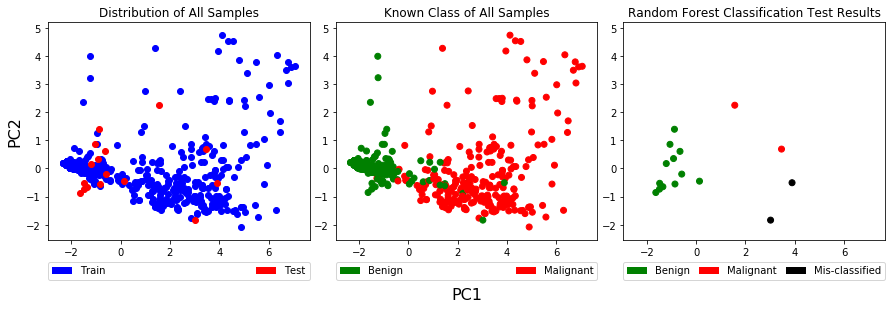

In [29]:
# ==RANDOM FOREST RESULTS PLOT================================================
my_plots("Random Forest", rf_pred_class)

The results of the RF classifier once again show the same two samples in the principle component space as misclassified. However, due to not using the PCA results for this classifier, this visualization can be taken a step further by identifying which variables contributed most to the decision trees in the classifier.

### Variable Importance

In the bar graph below, each of the 9 sample variables are ranked according to their importance in the decision making trees of the Random Forest. It is clearly shown that size uniformity makes up a large portion of the determinations.

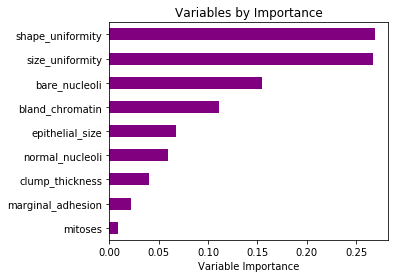

In [30]:
# Importance of each variable
importances = pd.DataFrame({'Feature': wisc.columns,
                            "Importance": rf_classifier.
                            feature_importances_}).sort_values(
                            by="Importance", ascending=True)

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

importances.plot(kind='barh', color='purple', ax=ax1)
y_pos = np.arange(len(importances))
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.yticks(y_pos, importances.Feature)
plt.title("Variables by Importance")
plt.show()
plt.close()

# Conclusions

From the results of all three classifiers, a clear trend emerges. Two samples, ID 1096800 and ID 704168, were repeatedly classified as malignant, even though the original new patient dataset labels them as benign. While this could indicate a high false positive rate in the classifiers, based off of the 3 approaches used and the Random Forest's confidence in the decision, in addition to the intuitive observation that these samples fall well out of the cluster of benign samples in the PCA, it would appear that these 2 patients have been misdiagnosed or mislabeled. 


***

# Part 2.2: Analysis of the "Bare Nucleoli" Variable

Recall that the original new patient dataset had originally been excluded due to missing "bare nucleoli" data. This data was then filled using a random distribution from the rest of the Wisconsin data set to allow for further analysis. In this section, rather than supply a random sample of values, the values will instead be set to 1.0, the median value from the Wisconsin set. This will essentially create a variable with zero variance, dampening its effect in the classifiers' decision making. All three classifiers will be tested against this modified dataset, with summary statistics and plots shown below. 

## Setting the Bare Nucleoli Values

In the code block below, a copy of the patient data is created. Its bare nucleoli values are then set to the median value of the same variable from the Wisconsin training set.

In [31]:
# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
# REPLACE BARE NUCLEOLI    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
nuke = pd.DataFrame(new_raw, columns=new_raw.columns)
for n in range(len(nuke)):
    nuke["bare_nucleoli"][n] = wisc_raw["bare_nucleoli"].median()

frames = [wisc_raw, nuke]
whole = pd.concat(frames, ignore_index=True)
whole = pd.DataFrame(scale(whole), columns=whole.columns)

wisc = pd.DataFrame(whole[:wisc_len], columns=whole.columns)
new = pd.DataFrame(whole[wisc_len:], columns=whole.columns)

## Classifying the Replaced Bare Nucleoli Set

Summary statistics and plots for the replaced new patient set are shown below for all three classifiers, relying on the same cross-validations and trainings from before to apply to this altered set.

### KNN of Replaced "Bare Nucleoli" Data


Confusion Matrix:

[[11  0]
 [ 3  2]]

Classification Report:

             precision    recall  f1-score   support

          0      1.000     0.786     0.880        14
          1      0.400     1.000     0.571         2

avg / total      0.925     0.812     0.841        16

Accuracy: 81.250%
Sensitivity: 100.000%
Precision: 40.000%
False Positive Rate: 21.429%


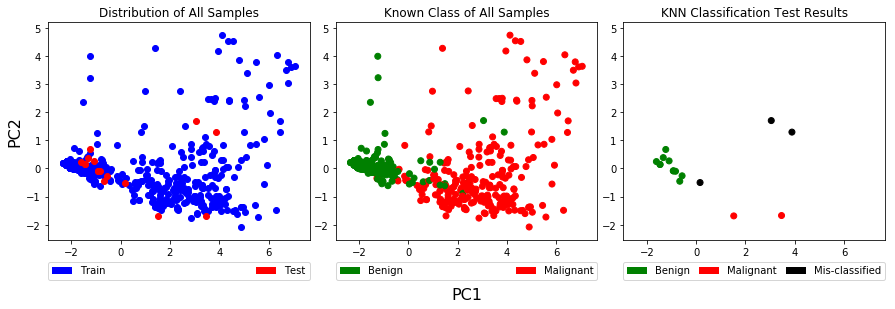

In [32]:
# ==PCA=======================================================================
pca_new = pd.DataFrame(pca2.fit_transform(new))
pc12_new = np.column_stack((pd.Series.tolist(pca_new[0]),
                            pd.Series.tolist(pca_new[1])))

pred7 = knn7.fit(pc12_wisc, classes).predict(pc12_new)
print("\nConfusion Matrix:\n")
print(confusion_matrix(classes_new, pred7).T)
print("\nClassification Report:\n")
print(classification_report(classes_new, pred7, digits=3))

# Get metrics on KNN test results
conf_mat_7 = metrics.confusion_matrix(classes_new, pred7)
TP7 = conf_mat_7[1, 1]*1.0
TN7 = conf_mat_7[0, 0]*1.0
FP7 = conf_mat_7[0, 1]*1.0
FN7 = conf_mat_7[1, 0]*1.0
print("Accuracy: {:.3%}".format((TP7 + TN7) / (TP7 + TN7 + FP7 + FN7)))
print("Sensitivity: {:.3%}".format(TP7 / (FN7 + TP7)))
print("Precision: {:.3%}".format(TP7 / (FP7 + TP7)))
print("False Positive Rate: {:.3%}".format(FP7 / (FP7 + TN7)))

# ==KNN PLOT==================================================================
my_plots("KNN", pred7)

### SVM of Replaced "Bare Nucleoli" Data

Recorded from data:  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Predicted from SVM:  [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]

Confusion Matrix:

[[12  0]
 [ 2  2]]

Classification Report:

             precision    recall  f1-score   support

          0      1.000     0.857     0.923        14
          1      0.500     1.000     0.667         2

avg / total      0.938     0.875     0.891        16

Accuracy: 87.500%
Sensitivity: 100.000%
Precision: 50.000%
False Positive Rate: 14.286%


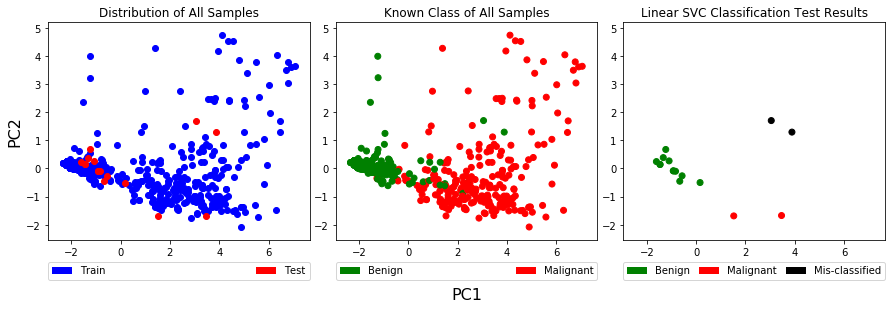

In [33]:
# ==LINEAR KERNEL SVC=========================================================
# Run the linear SVC test
pred_svc = svc.predict(pc12_new)


print("Recorded from data: ", list(classes_new))
print("Predicted from SVM: ", list(pred_svc))

# Get metrics on linear test results
print("\nConfusion Matrix:\n")
print(confusion_matrix(classes_new, pred_svc).T)
print("\nClassification Report:\n")
print(classification_report(classes_new, pred_svc, digits=3))

conf_mat2 = metrics.confusion_matrix(classes_new, pred_svc)
TP2 = conf_mat2[1, 1]*1.0
TN2 = conf_mat2[0, 0]*1.0
FP2 = conf_mat2[0, 1]*1.0
FN2 = conf_mat2[1, 0]*1.0

print("Accuracy: {:.3%}".format((TP2 + TN2) / (TP2 + TN2 + FP2 + FN2)))
print("Sensitivity: {:.3%}".format(TP2 / (FN2 + TP2)))
print("Precision: {:.3%}".format(TP2 / (FP2 + TP2)))
print("False Positive Rate: {:.3%}".format(FP2 / (FP2 + TN2)))

# ==LINEAR KERNEL SVC PLOT===================================================
my_plots("Linear SVC", pred_svc)

### Random Forest of Replaced "Bare Nucleoli" Data

Recorded from data:            [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Predicted from Random Forest:  [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]

Confusion Matrix:

[[12  0]
 [ 2  2]]

Classification Report:

             precision    recall  f1-score   support

          0      1.000     0.857     0.923        14
          1      0.500     1.000     0.667         2

avg / total      0.938     0.875     0.891        16

Accuracy: 87.500%
Sensitivity: 50.000%
Precision: 50.000%
False Positive Rate: 14.286%


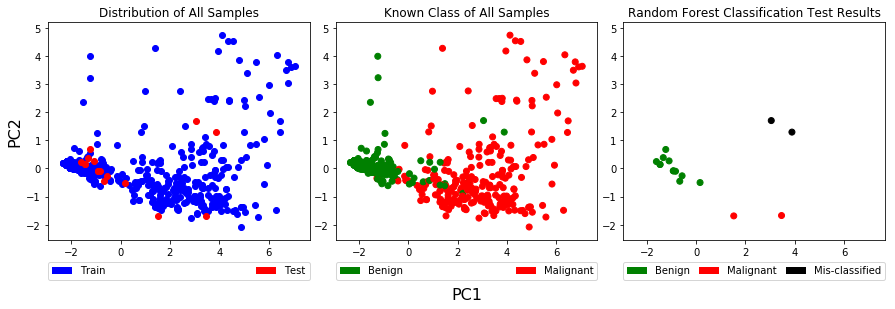

In [34]:
# ==RANDOM FOREST=============================================================
rf_prob_class = rf_classifier.predict_proba(new)
rf_pred_class = rf_classifier.predict(new)

print("Recorded from data:           ", list(classes_new))
print("Predicted from Random Forest: ", list(rf_pred_class))
print("\nConfusion Matrix:\n")
print(confusion_matrix(classes_new, rf_pred_class).T)
print("\nClassification Report:\n")
print(classification_report(classes_new, rf_pred_class, digits=3))

conf_mat4 = metrics.confusion_matrix(classes_new, rf_pred_class)
TP4 = conf_mat4[1, 1]*1.0
TN4 = conf_mat4[0, 0]*1.0
FP4 = conf_mat4[0, 1]*1.0
FN4 = conf_mat4[1, 0]*1.0
print("Accuracy: {:.3%}".format((TP4 + TN4) / (TP4 + TN4 + FP4 + FN4)))
print("Sensitivity: {:.3%}".format(TP4 / (FP4 + TP4)))
print("Precision: {:.3%}".format(TP4 / (FP4 + TP4)))
print("False Positive Rate: {:.3%}".format(FP4 / (FP4 + TN4)))
# ==RANDOM FOREST RESULTS PLOT================================================
my_plots("Random Forest", rf_pred_class)

In [35]:
rf_decs = pd.DataFrame(np.column_stack((rf_prob_class, rf_pred_class, classes_new)), columns=["Prob. 0", "Prob. 1", "Prediction", "Prerecorded"])
print(rf_decs)

    Prob. 0  Prob. 1  Prediction  Prerecorded
0      0.48     0.52         1.0          1.0
1      0.01     0.99         1.0          0.0
2      1.00     0.00         0.0          0.0
3      1.00     0.00         0.0          0.0
4      1.00     0.00         0.0          0.0
5      1.00     0.00         0.0          0.0
6      0.99     0.01         0.0          0.0
7      1.00     0.00         0.0          0.0
8      1.00     0.00         0.0          0.0
9      0.22     0.78         1.0          1.0
10     1.00     0.00         0.0          0.0
11     0.80     0.20         0.0          0.0
12     0.07     0.93         1.0          0.0
13     1.00     0.00         0.0          0.0
14     1.00     0.00         0.0          0.0
15     1.00     0.00         0.0          0.0


## Conclusions Regarding Replaced "Bare Nucleoli" Data

Despite shifting the PCA distribution of the test data somewhat, the modified test set did not alter the accuracy or outcome of the classifiers, and nearly all plots and figures are identical, with one exception. The Random Forest probability table shows markedly changed values for some samples when testing on this new dataset. For example, sample 3 was labelled benign with 67% probability in the original, but with 100% probability in the altered set, and sample 1 changed from a 96% malignant call to only 56% malignant. Across nearly all samples, confidence in benign calls increased, while confidence in malignant calls decreased. This provides evidence to suggest that "bare nucleoli" measurements may specifically serve to increase specificity, but also reduce sensitivity in breast cancer diagnostics.

